In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from scroutines import basicu
from scroutines.config_plots import *
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/scr/qlyu/projects/v1/scroutines/scroutines/basicu.py'>

In [2]:
sns.set_context('talk')

# get data

In [3]:
ddir = '../data/cheng21_cell_scrna/organized/'
files = [
    # 'P8NR.h5ad',
    # 'P14NR.h5ad',
    'P17NR.h5ad',
    'P21NR.h5ad',
    'P28NR.h5ad',
    'P38NR.h5ad',
    
#     'P28DR.h5ad',
#     'P38DR.h5ad',
    
#     'P28DL.h5ad',
] 

In [4]:
conds = np.array([f.replace('.h5ad', '') for f in files])
conds

array(['P17NR', 'P21NR', 'P28NR', 'P38NR'], dtype='<U5')

In [5]:
pbulks = []
xclsts = []
xcnsts = []

ncond, nrep, nclst, ngene = len(files), 2, 3,-1

for f in files:
    print(f)
    
    path = os.path.join(ddir, f)
    adata = anndata.read(path)
    genes = adata.var.index.values
    
    adata = adata[adata.obs['Subclass'] == 'L2/3']
    mat = adata.X
    types = adata.obs['Type'].astype(str).values 
    # 1 or 2
    sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1][:-1].replace('3', '2')).astype(str).values
    # sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1].replace('3', '2')).astype(str).values
    sample_and_type = sample_codes + "_" + types
    unqs, cnts = np.unique(sample_and_type, return_counts=True)
    _xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(mat, sample_and_type) 
    
    # check all types + reps are the same
    if len(xclsts) > 0:
        if not np.all(_xclsts == xclsts):
            raise ValueError(_xclsts.shape, xclsts.shape, _xclsts, xclsts,)
        if not np.all(_xclsts == unqs):
            raise ValueError(_xclsts.shape, unqs.shape, _xclsts, unqs,)
    else:
        xclsts = _xclsts
        print(xclsts)
        
    print(Xk_ln.shape)
    pbulks.append(Xk_ln)
    xcnsts.append(cnts)
    
pbulks = np.array(pbulks)
xcnsts = np.array(xcnsts)
print(pbulks.shape)
pbulks = pbulks.reshape(ncond,nrep,nclst,-1)
xcnsts = xcnsts.reshape(ncond,nrep,nclst)
xclsts = xclsts.reshape(      nrep,nclst)
print(pbulks.shape)

P17NR.h5ad
['1_L2/3_A' '1_L2/3_B' '1_L2/3_C' '2_L2/3_A' '2_L2/3_B' '2_L2/3_C']
(6, 53801)
P21NR.h5ad
(6, 53801)
P28NR.h5ad
(6, 53801)
P38NR.h5ad
(6, 53801)
(4, 6, 53801)
(4, 2, 3, 53801)


In [6]:
# check the pbulks are good -- log10(CPM+1) for each sample
checkpbulks = np.sum(np.power(10, pbulks)-1, axis=-1)
checkpbulks.shape, np.all(np.abs(checkpbulks-1e6) < 1e-6)

((4, 2, 3), True)

In [7]:
# xclsts_short = np.array([clst[len("1a_"):] for clst in xclsts[0]]) #, '_'
xclsts_short = np.array([clst[len("1_"):] for clst in xclsts[0]]) #, '_'
xclsts_short

array(['L2/3_A', 'L2/3_B', 'L2/3_C'], dtype='<U6')

# filter out small bulk profiles

In [8]:
numcells = pd.DataFrame(xcnsts.T.reshape(-1,nrep*ncond), index=xclsts_short)
numcells

,0,1,2,3,4,5,6,7
L2/3_A,568,490,296,114,472,715,316,361
L2/3_B,1640,1060,1218,475,1537,1318,1164,1346
L2/3_C,821,379,557,131,646,503,493,270


In [9]:
numcells.min(axis=1).sort_values()

L2/3_A    114
L2/3_C    131
L2/3_B    475
dtype: int64

In [10]:
xclsts_sel = xclsts_short[numcells.min(axis=1)>50]
unq_types = xclsts_sel
xclsts_selidx = basicu.get_index_from_array(xclsts_short, xclsts_sel)
pbulks = pbulks[:,:,xclsts_selidx,:]
xclsts_sel, xclsts_selidx

(array(['L2/3_A', 'L2/3_B', 'L2/3_C'], dtype='<U6'), array([0, 1, 2]))

# check the L23 type genes 

In [13]:
f = "../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq.csv"
df = pd.read_csv(f, header=None)
genes_l23 = df[0]
genes_l23_grps = df[1]
assert len(genes_l23.unique()) == len(genes_l23)
df

,0,1
0,Matn2,A2
1,Fam126a,A2
2,Egfem1,A2
3,Gm19410,A2
4,Grk3,A2
...,...,...
281,Brinp3,C3
282,Ell2,C3
283,Gm21949,C3
284,Jdp2,C3


In [14]:
genes_l23_grps.apply(lambda x: x[0]).value_counts().sort_index()

A    122
B     35
C    129
Name: 1, dtype: int64

In [15]:
gene_counts = [122, 35, 129]
gene_counts

[122, 35, 129]

In [16]:
f = "../results/MERFISH_gene_panel_current_Feb28.csv"
df = pd.read_csv(f)
df = df[df['why included'].str.contains('L2/3 subtypes') & 
        df['source'].str.contains('Cheng22_Cell')
       ]

cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

df

122 (122,) [] []


,gene_name_vizgen,gene_name_data,why included,source,Annot1,Annot2,Annot3
0,Matn2,Matn2,L2/3 subtypes,Cheng22_Cell,A>C>B,screened,NaN
1,Egfem1,Egfem1,L2/3 subtypes;NRvsDR_DEG,Cheng22_Cell;our analysis,A>C>B,screened,NaN
2,Grb14,Grb14,L2/3 subtypes,Cheng22_Cell,A>C>B,*,NaN
3,Adamts17,Adamts17,L2/3 subtypes,Cheng22_Cell,A>C>B,*,NaN
4,Ldb2,Ldb2,L2/3 subtypes,Cheng22_Cell,A>C>B,*,NaN
...,...,...,...,...,...,...,...
117,Kcnq5,Kcnq5,L2/3 subtypes,Cheng22_Cell,C>B>A,IC,NaN
118,Mkx,Mkx,L2/3 subtypes,Cheng22_Cell,C>B>A,TF,NaN
119,Brinp3,Brinp3,All cell types;L2/3 subtypes;L2/3 dynamic,Chen22_biorxiv_Zador;Cheng22_Cell;our analysis,C>B>A,**,also top single cell L6 CT_B marker
120,Ell2,Ell2,L2/3 subtypes,Cheng22_Cell,C>B>A,TF,NaN


In [17]:
assert np.intersect1d(cnddts, genes_l23).shape == cnddts.shape

In [18]:
# gidx_sub = basicu.get_index_from_array(genes_l23, cnddts)
# ispicked = np.array([g in cnddts for g in genes_l23])
# gidx_sub, ispicked
genes_l23 = [g for g in genes_l23 if g in cnddts]
ispicked = np.array([True]*len(cnddts))

In [19]:
gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(gidx!=-1)
xlbls = [''.join(i) for i in itertools.product(['A_', 'B_', 'C_'], ['P17', 'P21', 'P28', 'P38'], ['_1', '_2'])]
pbulks.shape, xlbls

((4, 2, 3, 53801),
 ['A_P17_1',
  'A_P17_2',
  'A_P21_1',
  'A_P21_2',
  'A_P28_1',
  'A_P28_2',
  'A_P38_1',
  'A_P38_2',
  'B_P17_1',
  'B_P17_2',
  'B_P21_1',
  'B_P21_2',
  'B_P28_1',
  'B_P28_2',
  'B_P38_1',
  'B_P38_2',
  'C_P17_1',
  'C_P17_2',
  'C_P21_1',
  'C_P21_2',
  'C_P28_1',
  'C_P28_2',
  'C_P38_1',
  'C_P38_2'])

In [20]:
xlbls_short = []
for i, xlbl in enumerate(xlbls):
    if i%(4*2) == 0:
        short = "_".join(xlbl.split("_")[:2])
    else:
        short = xlbl.split("_")[1]
    if i%2 == 1:
        short = "" #xlbl.split("_")[-1]
    xlbls_short.append(short)
    
xlbls_short 

['A_P17',
 '',
 'P21',
 '',
 'P28',
 '',
 'P38',
 '',
 'B_P17',
 '',
 'P21',
 '',
 'P28',
 '',
 'P38',
 '',
 'C_P17',
 '',
 'P21',
 '',
 'P28',
 '',
 'P38',
 '']

In [21]:
pbsub_a = basicu.merge_first_few_dims(pbulks[:,:,0,gidx]).T
pbsub_b = basicu.merge_first_few_dims(pbulks[:,:,1,gidx]).T
pbsub_c = basicu.merge_first_few_dims(pbulks[:,:,2,gidx]).T
pbsub   = np.hstack([pbsub_a, pbsub_b, pbsub_c]) 

pbsub_logfc = pbsub-np.mean(pbsub, axis=1).reshape(-1,1)
pbsub_zscore = pbsub_logfc/np.std(pbsub_logfc, axis=1).reshape(-1,1) #-np.mean(pbsub, axis=1).reshape(-1,1)

In [22]:
maxexp = np.max([np.mean(pbsub_a, axis=1), 
                 np.mean(pbsub_b, axis=1), 
                 np.mean(pbsub_c, axis=1),
                ], axis=0)

minexp = np.min([np.mean(pbsub_a, axis=1), 
                 np.mean(pbsub_b, axis=1), 
                 np.mean(pbsub_c, axis=1),
                ], axis=0)
lfcexp = maxexp-minexp

lfcorder = np.argsort(lfcexp)
maxorder = np.argsort(maxexp)
minorder = np.argsort(minexp)

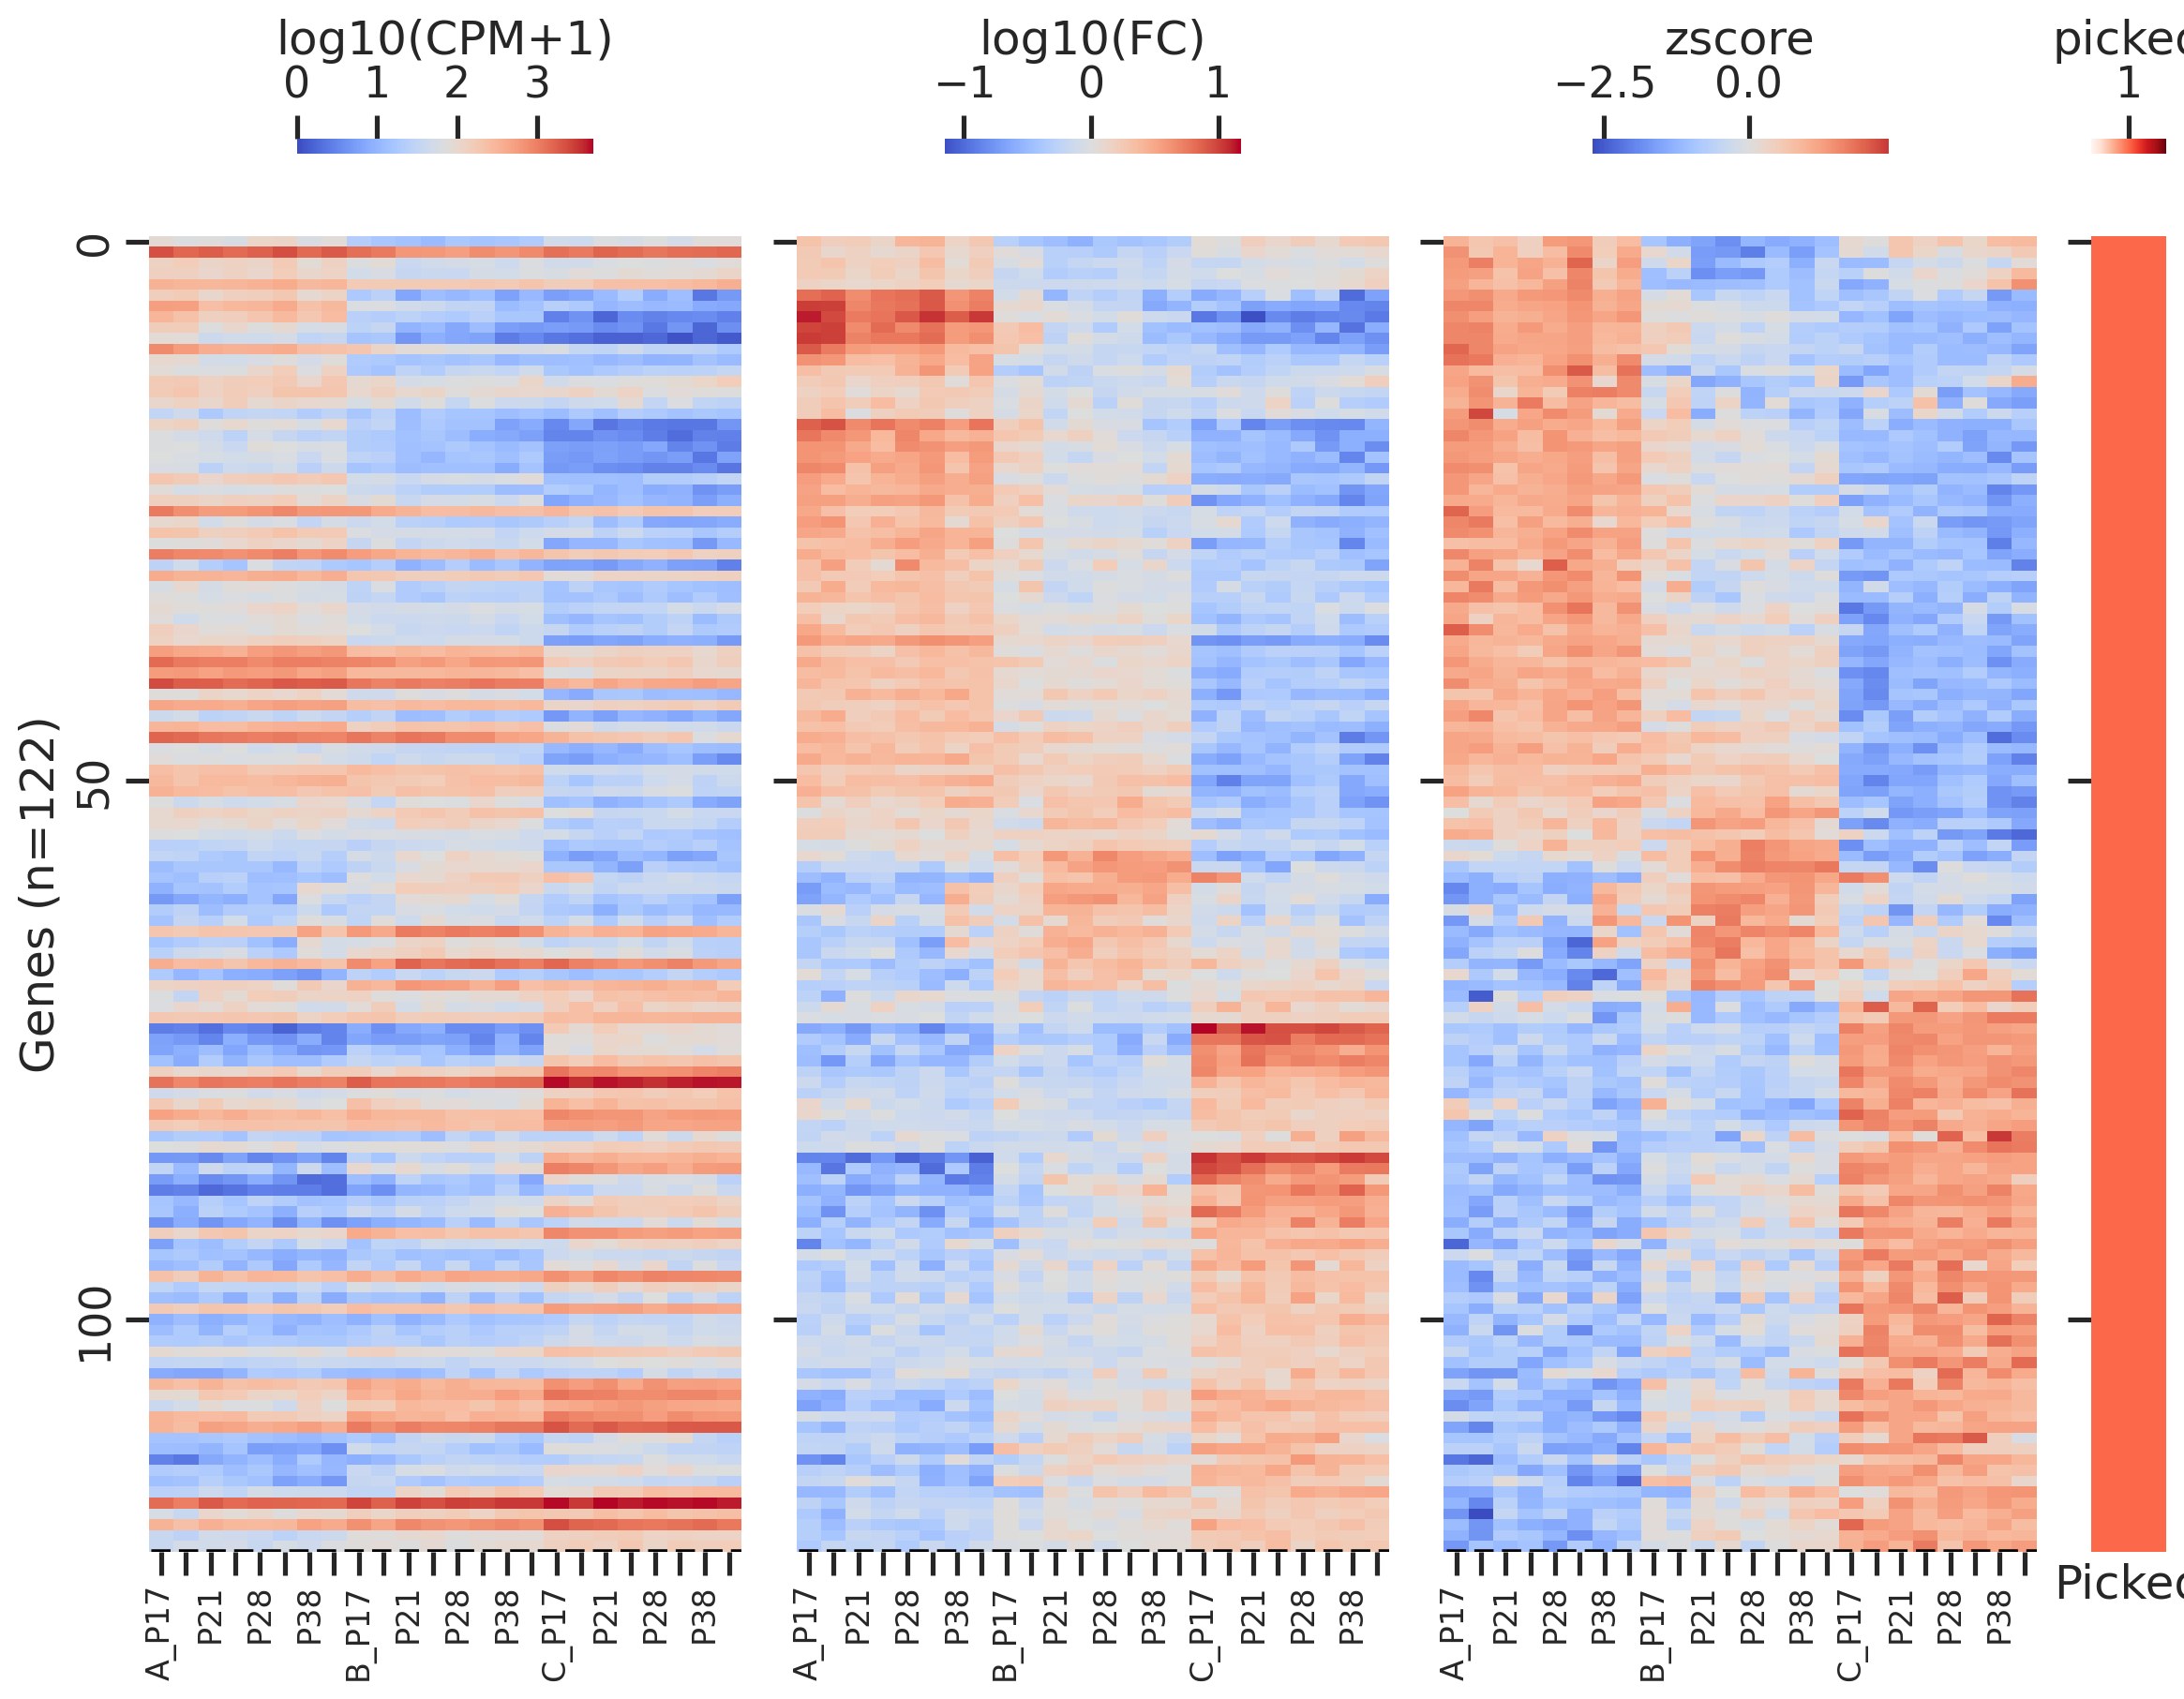

In [23]:

# fig, axs = plt.subplots(1, 3, figsize=(3*4,10), sharey=True)

fig, axs = plt.subplot_mosaic("A"*5+"B"*5+"C"*5+"D", figsize=(3*4,10), sharey=True)
# fig.suptitle(f'L2/3 type genes \n(n={len(pbsub_a)})', fontsize=15)

ax = axs["A"]
sns.heatmap(pbsub, #[rowidx],
            yticklabels=50,
            xticklabels=xlbls_short, # tsdup,
            cmap='coolwarm', 
            cbar_kws=dict(location='top', shrink=0.5, label='log10(CPM+1)', ticks=[0,1,2,3]),
            vmin=0, 
            ax=ax,
           )
ax.hlines(np.cumsum(gene_counts), xmin=-1, xmax=pbsub.shape[1]+1, color='black', linewidth=2, linestyle='--')
ax.set_ylabel(f'Genes (n={len(pbsub_a)})')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

ax = axs["B"]
sns.heatmap(pbsub_logfc, #[rowidx],
            yticklabels=50,
            xticklabels=xlbls_short, # tsdup,
            cmap='coolwarm', 
            cbar_kws=dict(location='top', shrink=0.5, label='log10(FC)'),
            center=0,
            ax=ax,
           )
ax.hlines(np.cumsum(gene_counts), xmin=-1, xmax=pbsub.shape[1]+1, color='black', linewidth=2, linestyle='--')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

ax = axs["C"]
sns.heatmap(pbsub_zscore, #[rowidx],
            yticklabels=50,
            xticklabels=xlbls_short, # tsdup,
            cmap='coolwarm', 
            cbar_kws=dict(location='top', shrink=0.5, label='zscore'),
            center=0,
            ax=ax,
           )
ax.hlines(np.cumsum(gene_counts), xmin=-1, xmax=pbsub.shape[1]+1, color='black', linewidth=2, linestyle='--')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

ax = axs["D"]
sns.heatmap(ispicked.reshape(-1,1), #[rowidx],
            yticklabels=50,
            xticklabels=False, 
            cmap='Reds', 
            cbar_kws=dict(location='top', shrink=1, ticks=[0,1], label='picked', aspect=5),
            ax=ax,
           )
ax.set_xlabel('Picked')

fig.tight_layout()
plt.show()

In [24]:
def plot_l23genes(order=None):
    """
    """
    n = len(maxexp)
    if order is None:
        order = np.arange(n)
        
    fig, axs = plt.subplots(2,1,figsize=(1*10,2*3), sharex=True)
    ax = axs[0]
    ax.plot(maxexp[order], label='max type') #, color='C1')
    ax.plot(minexp[order], label='min type') #, color='k')
    ax.scatter(np.arange(n)[ispicked[order]], maxexp[order][ispicked[order]], s=5, color='r', zorder=2, label=f'picked n={ispicked.sum()}')
    ax.set_ylabel('log10(CPM+1)')
    sns.despine(ax=ax)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

    ax = axs[1]
    ax.plot(lfcexp[order], color='k')
    ax.axhline(np.log10(2), color='gray', linestyle='--', label='2-fold')
    ax.scatter(np.arange(n)[ispicked[order]], lfcexp[order][ispicked[order]], s=5, color='r', zorder=2, label=f'picked n={ispicked.sum()}')
    ax.set_ylabel('log10FC\n(max type/min type)')
    ax.set_xlabel('L2/3 genes')
    sns.despine(ax=ax)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

    fig.tight_layout()
    plt.show()

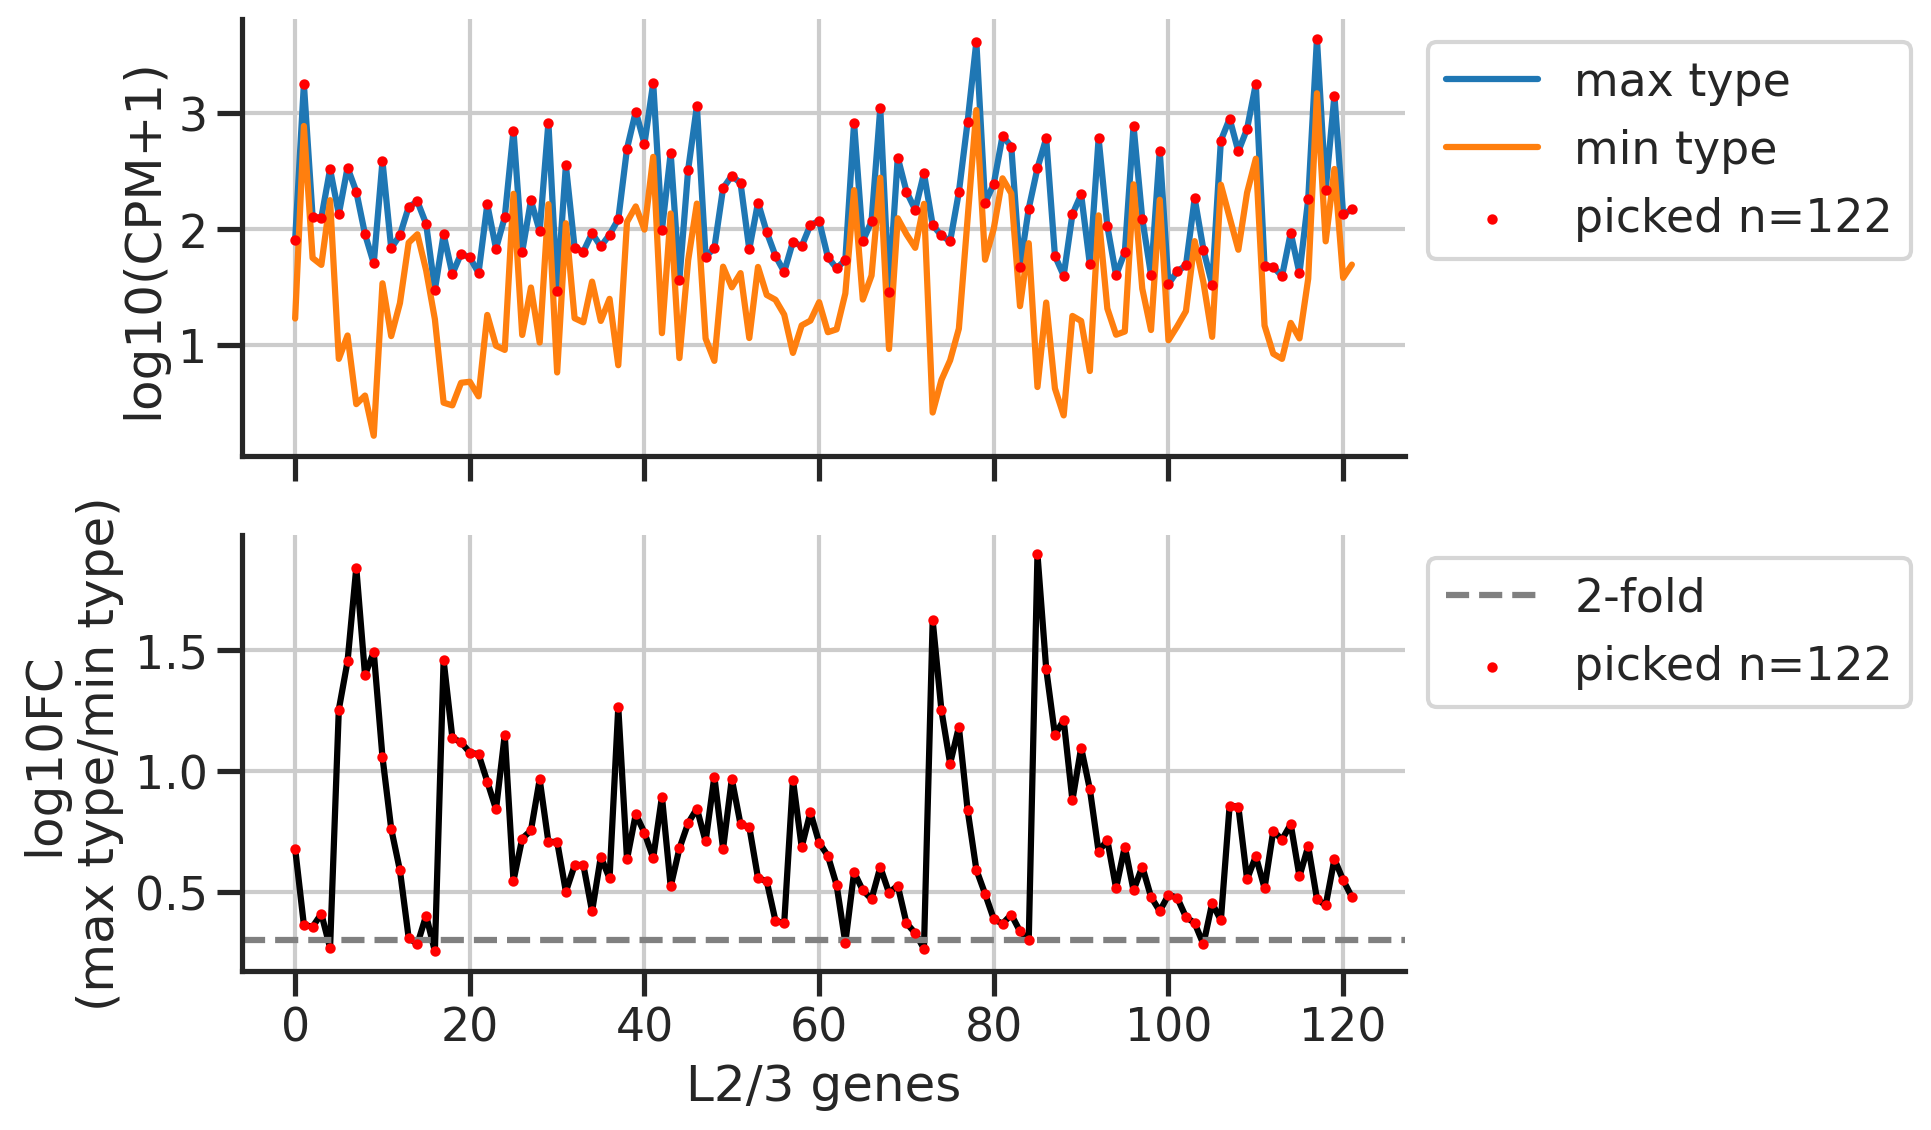

In [25]:
plot_l23genes()

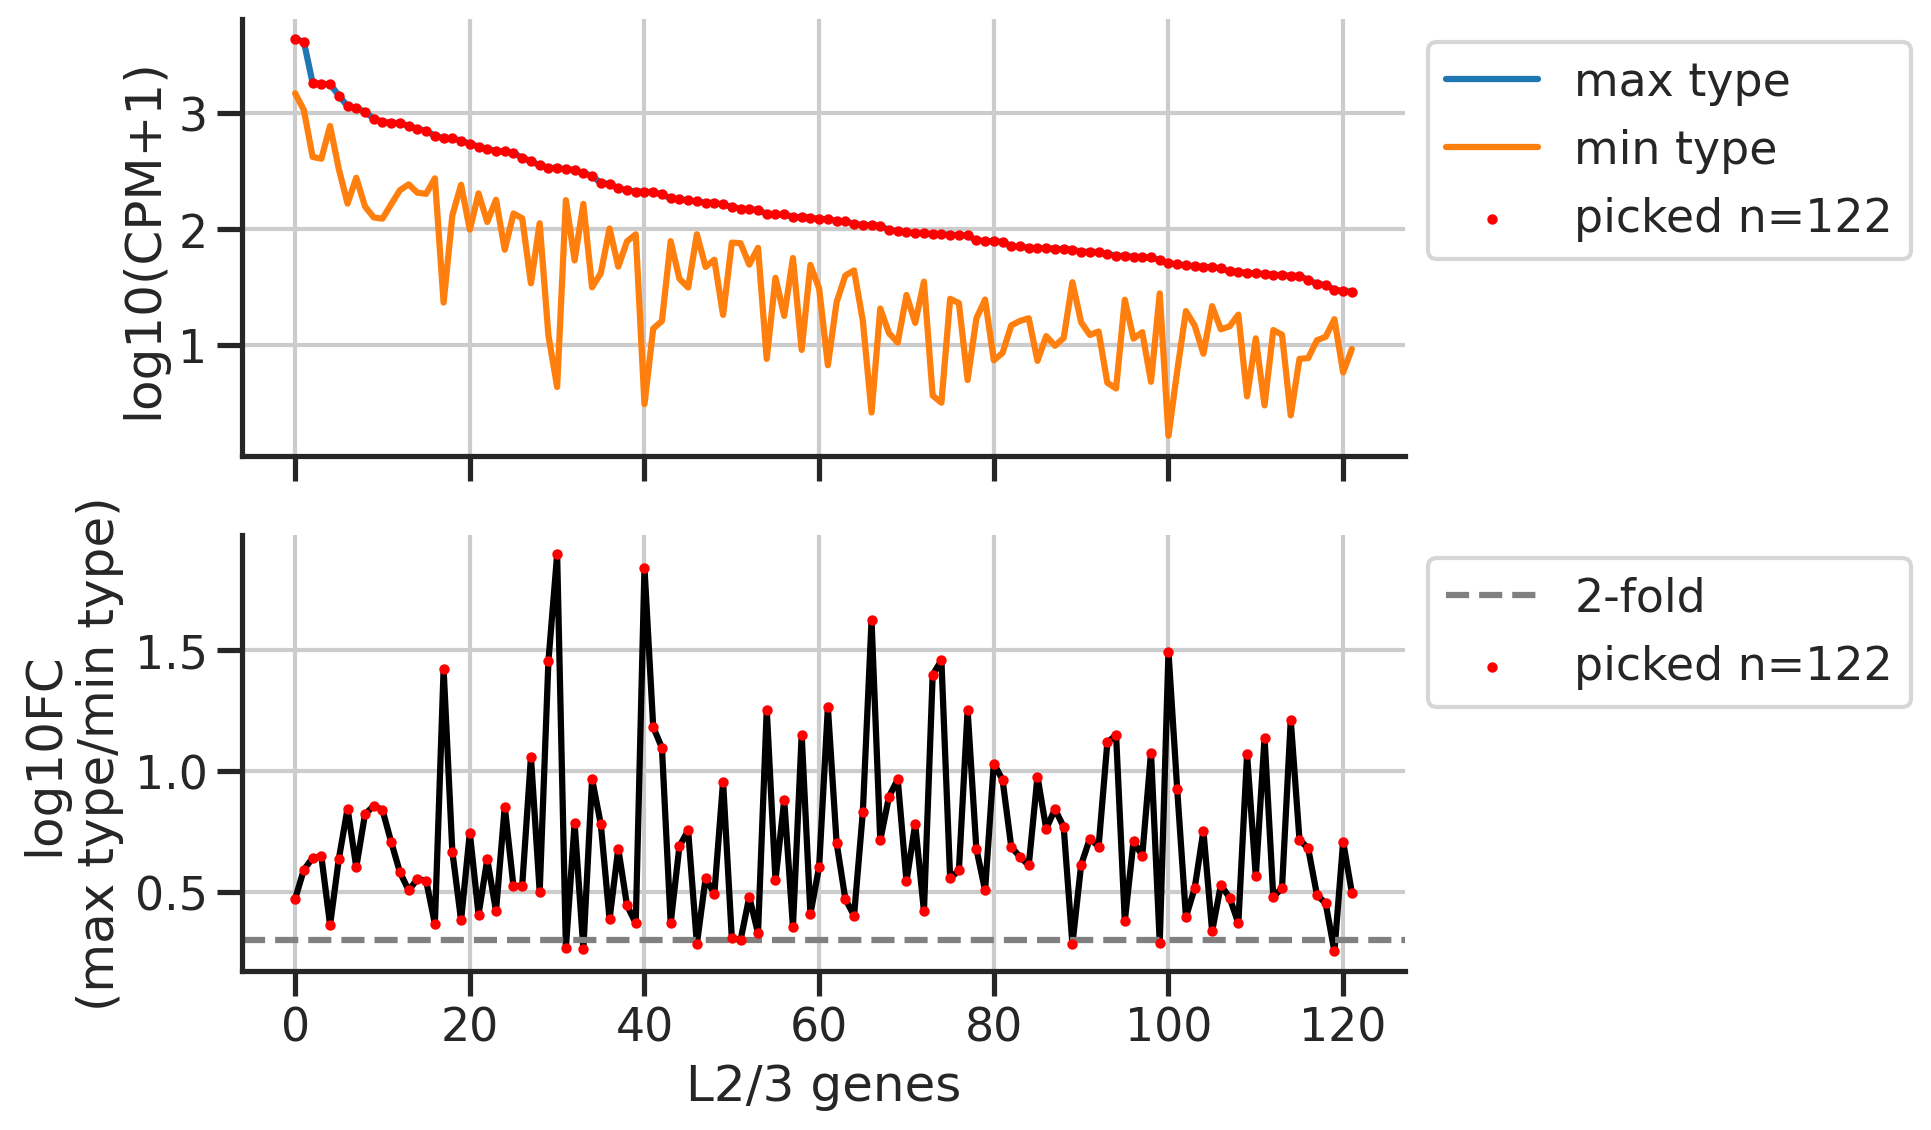

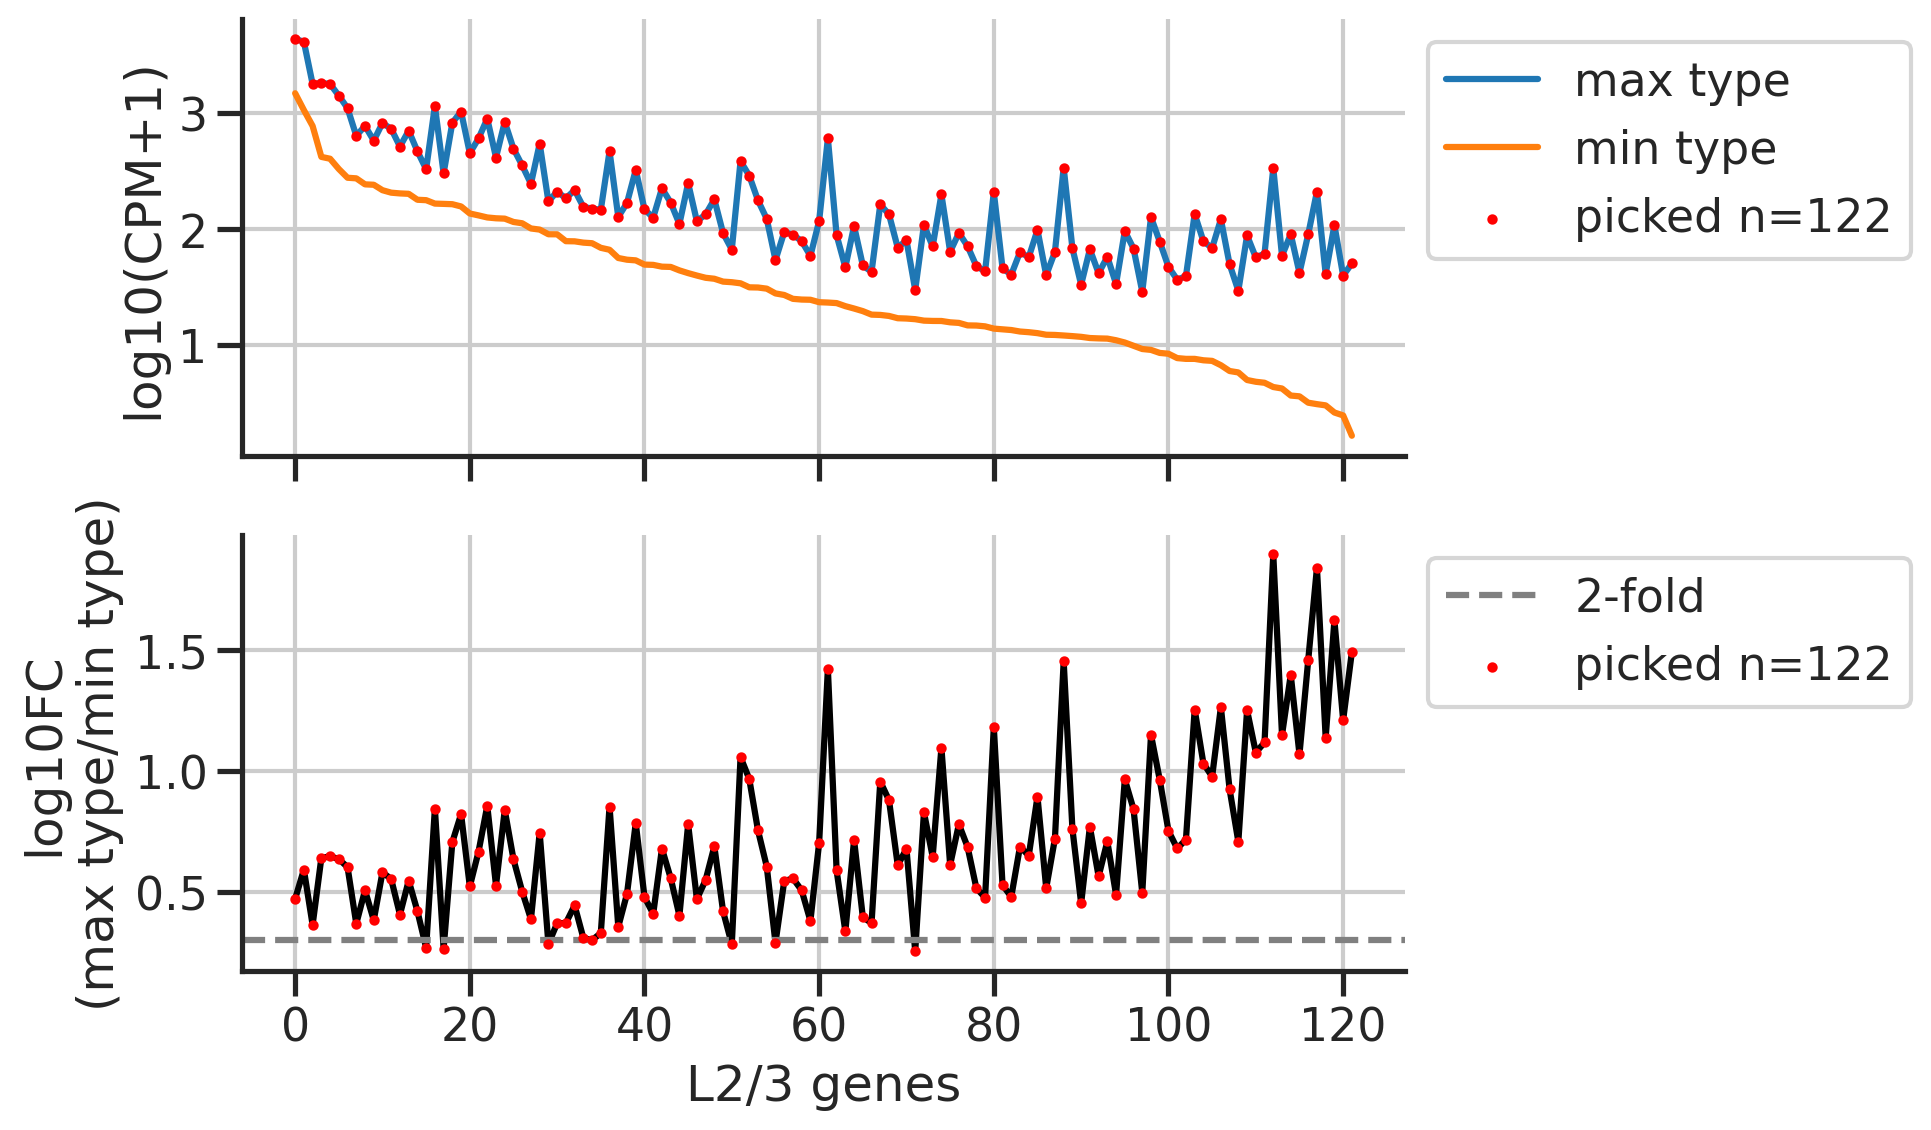

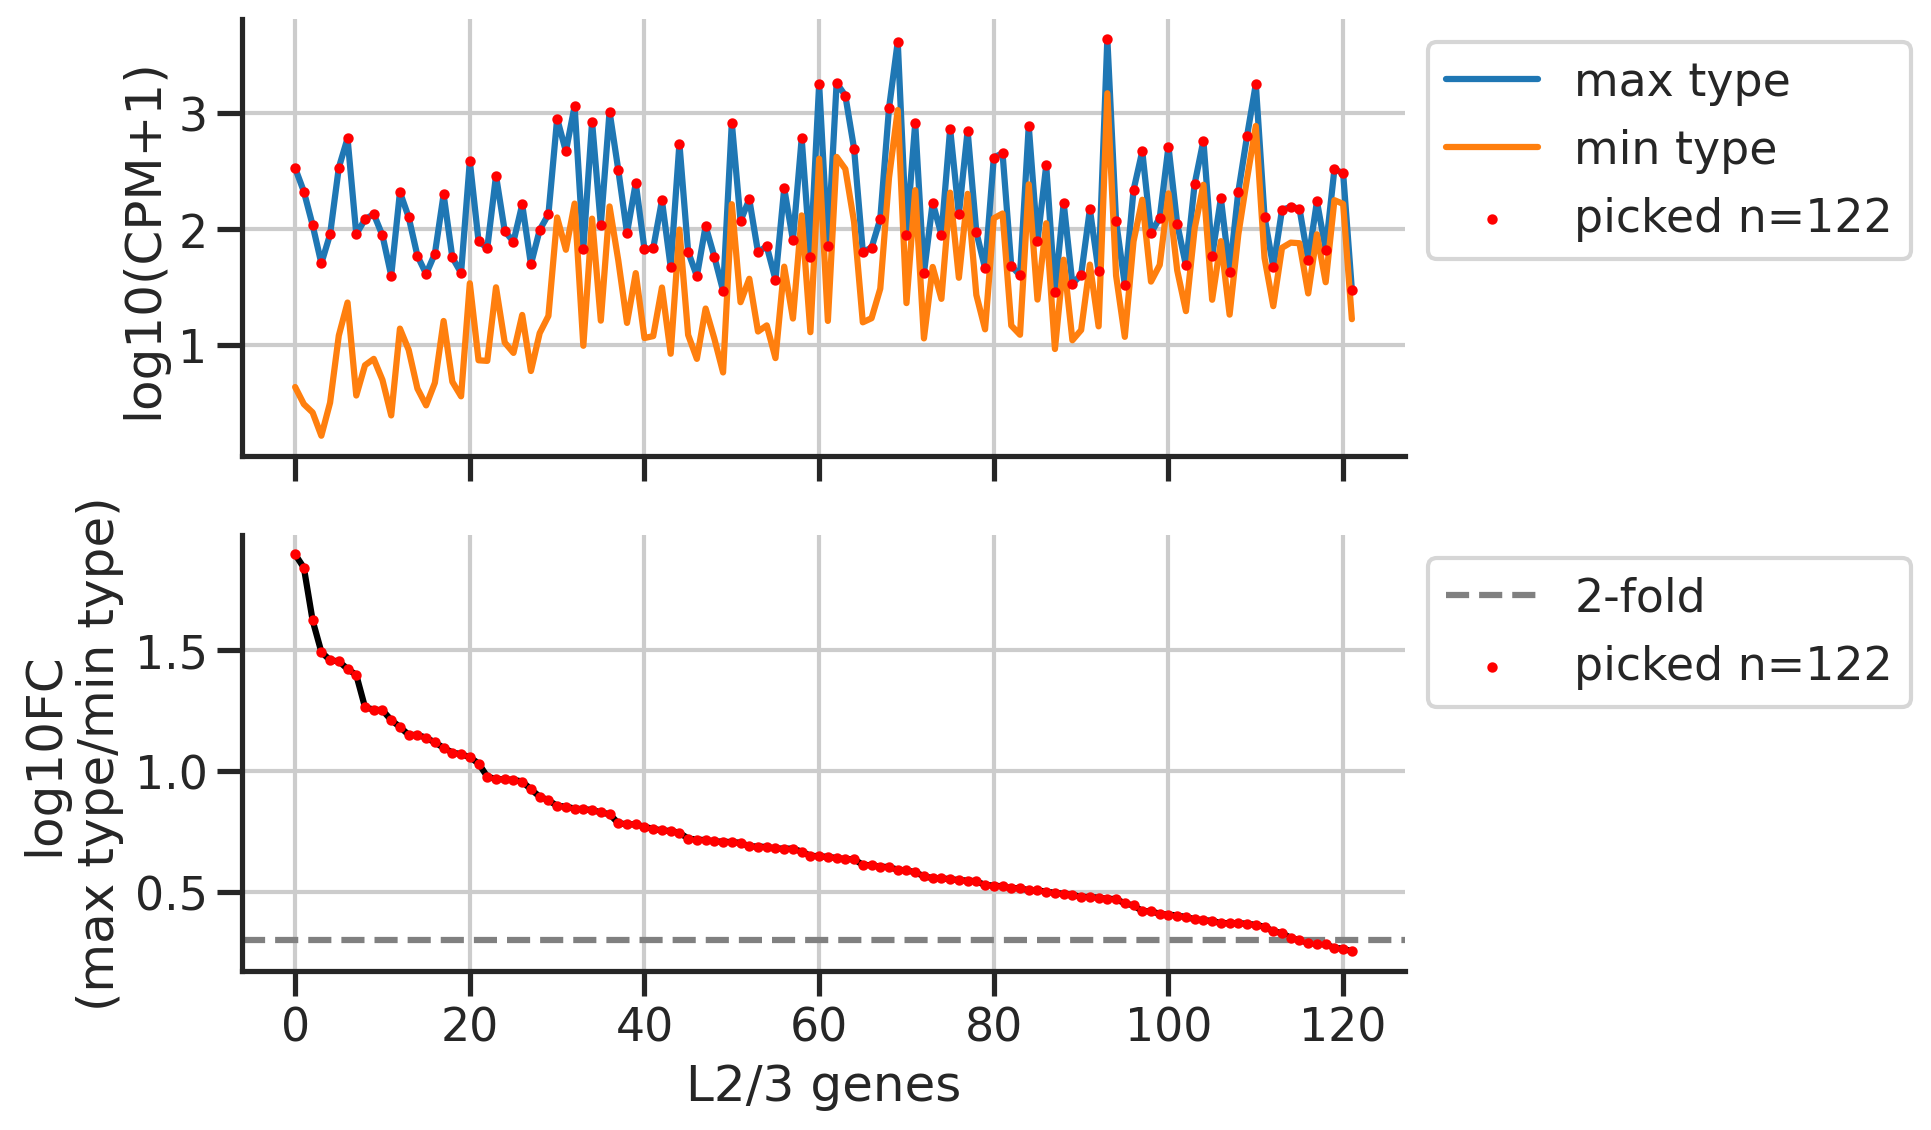

In [26]:
plot_l23genes(order=maxorder[::-1])
plot_l23genes(order=minorder[::-1])
plot_l23genes(order=lfcorder[::-1])